### Load dataset

In [1]:
import pandas as pd

# Load the data
temp_data = pd.read_csv('colombo_t_2012-2018.csv')
rh_data = pd.read_csv('colombo_rh_2012-2018.csv')


print(temp_data.head())
print(rh_data.head())

   station_id station_name element_name  year  month  day  obs_val
0       43466      COLOMBO       TMPMAX  2012      1    1     30.1
1       43466      COLOMBO       TMPMAX  2012      1    2     30.7
2       43466      COLOMBO       TMPMAX  2012      1    3     31.6
3       43466      COLOMBO       TMPMAX  2012      1    4     30.4
4       43466      COLOMBO       TMPMAX  2012      1    5     32.3
   station_id station_name element_name  year  month  day  obs_val
0       43466      COLOMBO        RHMAX  2012      1    1     91.0
1       43466      COLOMBO        RHMAX  2012      1    2     90.0
2       43466      COLOMBO        RHMAX  2012      1    3     89.0
3       43466      COLOMBO        RHMAX  2012      1    4     89.0
4       43466      COLOMBO        RHMAX  2012      1    5     95.0


### Preprocess the Data

In [2]:
# Convert the temperature from Celsius to Fahrenheit for the heat index calculation
temp_data['temp_F'] = temp_data['obs_val'] * 9/5 + 32

# Merge the temperature and humidity datasets on year, month, and day
combined_data = pd.merge(temp_data, rh_data, on=['year', 'month', 'day'], suffixes=('_temp', '_rh'))

### Calculate the Heat Index(HI)

In [3]:
# Calculate the Heat Index using the provided formula
T = combined_data['temp_F']
RH = combined_data['obs_val_rh']
combined_data['HI'] = (-42.379 + 2.04901523 * T + 10.14333127 * RH 
                       - 0.22475541 * T * RH - 0.00683783 * T**2 - 0.05481717 * RH**2 
                       + 0.00122874 * T**2 * RH + 0.00085282 * T * RH**2 
                       - 0.00000199 * T**2 * RH**2)

# Assuming combined_data already has the year, month, and day columns
combined_data['date'] = pd.to_datetime(combined_data[['year', 'month', 'day']], errors='coerce')

# Drop any rows where the date could not be formed correctly
combined_data = combined_data.dropna(subset=['date'])

# Set the datetime index
combined_data.set_index('date', inplace=True)

### ARIMA Forecasting

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Filter the data for the recent period (e.g., last 2 years for fresher data)
recent_data = combined_data.last('24M')['HI']

# Fit an ARIMA model
model = ARIMA(recent_data, order=(1,1,1))
fit_model = model.fit()

# Forecast past 12 months and next 12 months
past_12_months = fit_model.predict(start=recent_data.index[-12], end=recent_data.index[-1])
next_12_months = fit_model.forecast(steps=12)


D:\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Softwares\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [5]:
print("Past 12 Months Predicted HI:")
print(past_12_months)

print("\nNext 12 Months Forecasted HI:")
print(next_12_months)


Past 12 Months Predicted HI:
date
2018-12-28    108.234366
2018-12-28    107.666333
2018-12-28    106.942428
2018-12-29    107.281973
2018-12-29    107.214223
2018-12-29    106.762240
2018-12-30    106.949259
2018-12-30    107.926724
2018-12-30    106.739231
2018-12-31    108.015782
Name: predicted_mean, dtype: float64

Next 12 Months Forecasted HI:
2555    107.474174
2556    107.380552
2557    107.376068
2558    107.375854
2559    107.375843
2560    107.375843
2561    107.375843
2562    107.375843
2563    107.375843
2564    107.375843
2565    107.375843
2566    107.375843
Name: predicted_mean, dtype: float64


### Visualizations

#### Visualize the Historical Heat Index Data

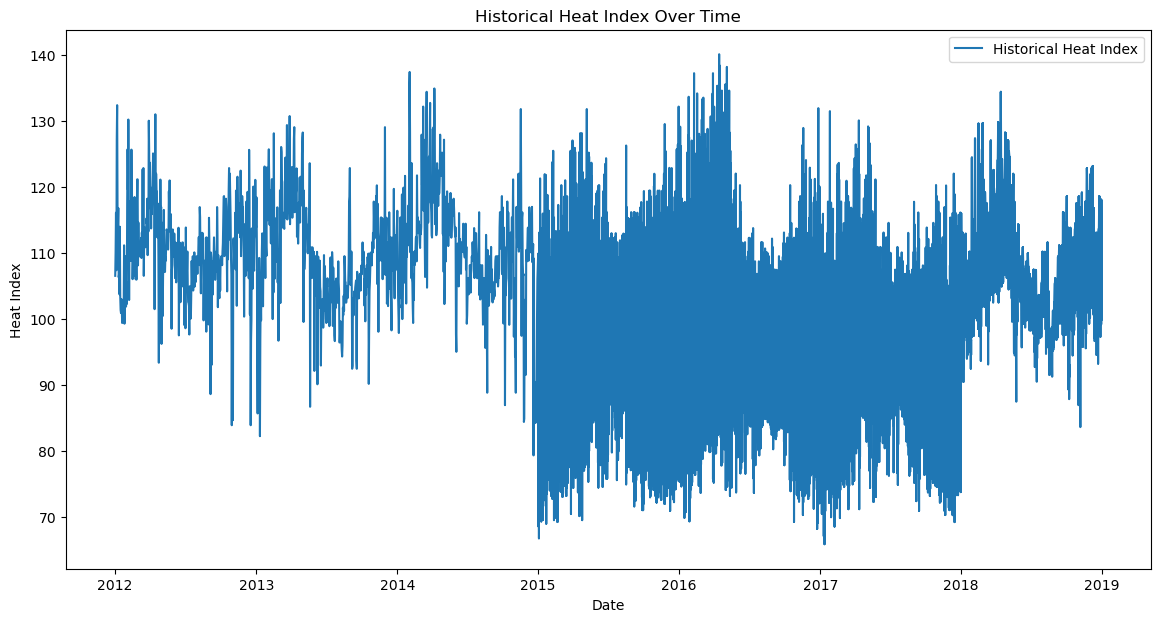

In [9]:
import matplotlib.pyplot as plt

# Plotting the historical Heat Index data
plt.figure(figsize=(14, 7))
plt.plot(combined_data['HI'], label='Historical Heat Index')
plt.title('Historical Heat Index Over Time')
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.legend()
plt.show()

#### Visualize the ARIMA Predictions for the Past 12 Months

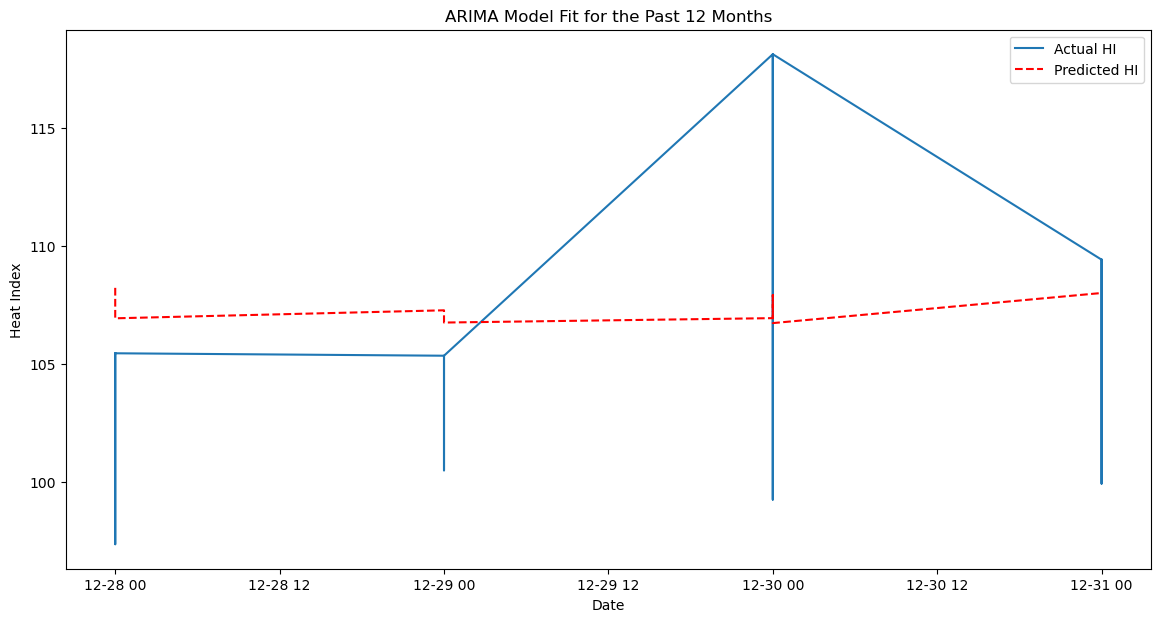

In [10]:
# Plotting the ARIMA predictions for the past 12 months
plt.figure(figsize=(14, 7))
plt.plot(recent_data.index[-12:], recent_data[-12:], label='Actual HI')
plt.plot(past_12_months.index, past_12_months, color='red', linestyle='--', label='Predicted HI')
plt.title('ARIMA Model Fit for the Past 12 Months')
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.legend()
plt.show()

In [1]:
plt.savefig('D:/SLIIT/Y4/Lecs/IOTBDA/Assignment/IT4021_IoTBDA_Assignment_v1.0/Document Templates/ARIMA Model Fit for the Past 12 Months.png')

NameError: name 'plt' is not defined

#### Visualize the ARIMA Forecast for the Next 12 Months

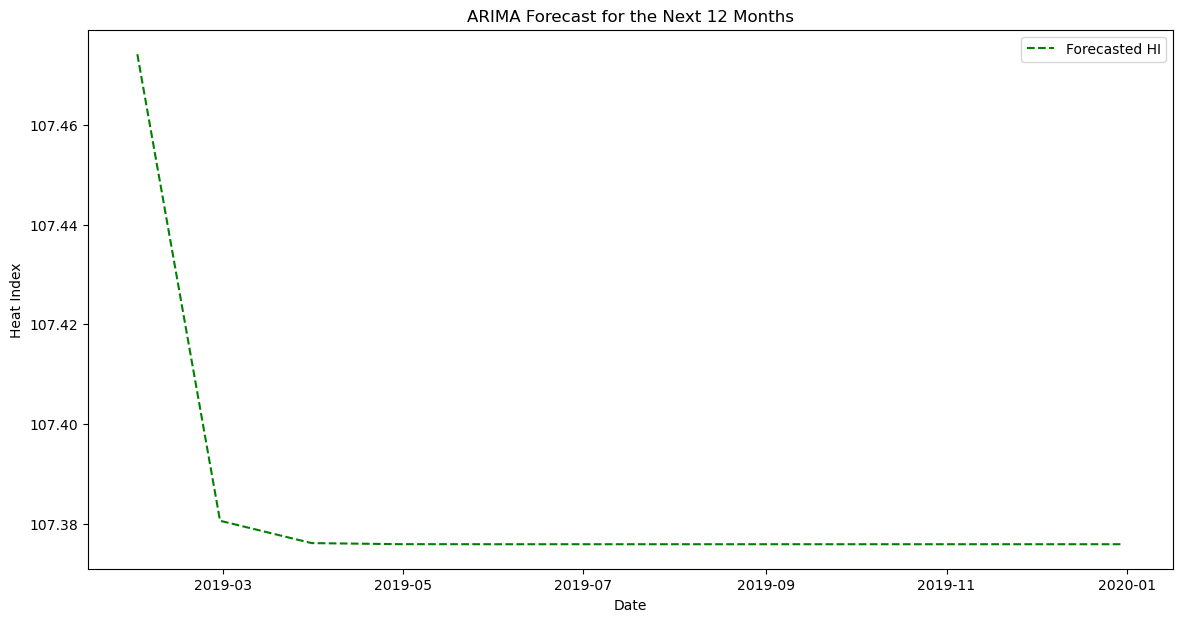

In [11]:
# Forecast dates setup
forecast_dates = pd.date_range(start=combined_data.index[-1], periods=13, freq='M')[1:]

# Plotting the ARIMA forecast for the next 12 months
plt.figure(figsize=(14, 7))
plt.plot(forecast_dates, next_12_months, color='green', linestyle='--', label='Forecasted HI')
plt.title('ARIMA Forecast for the Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.legend()
plt.show()

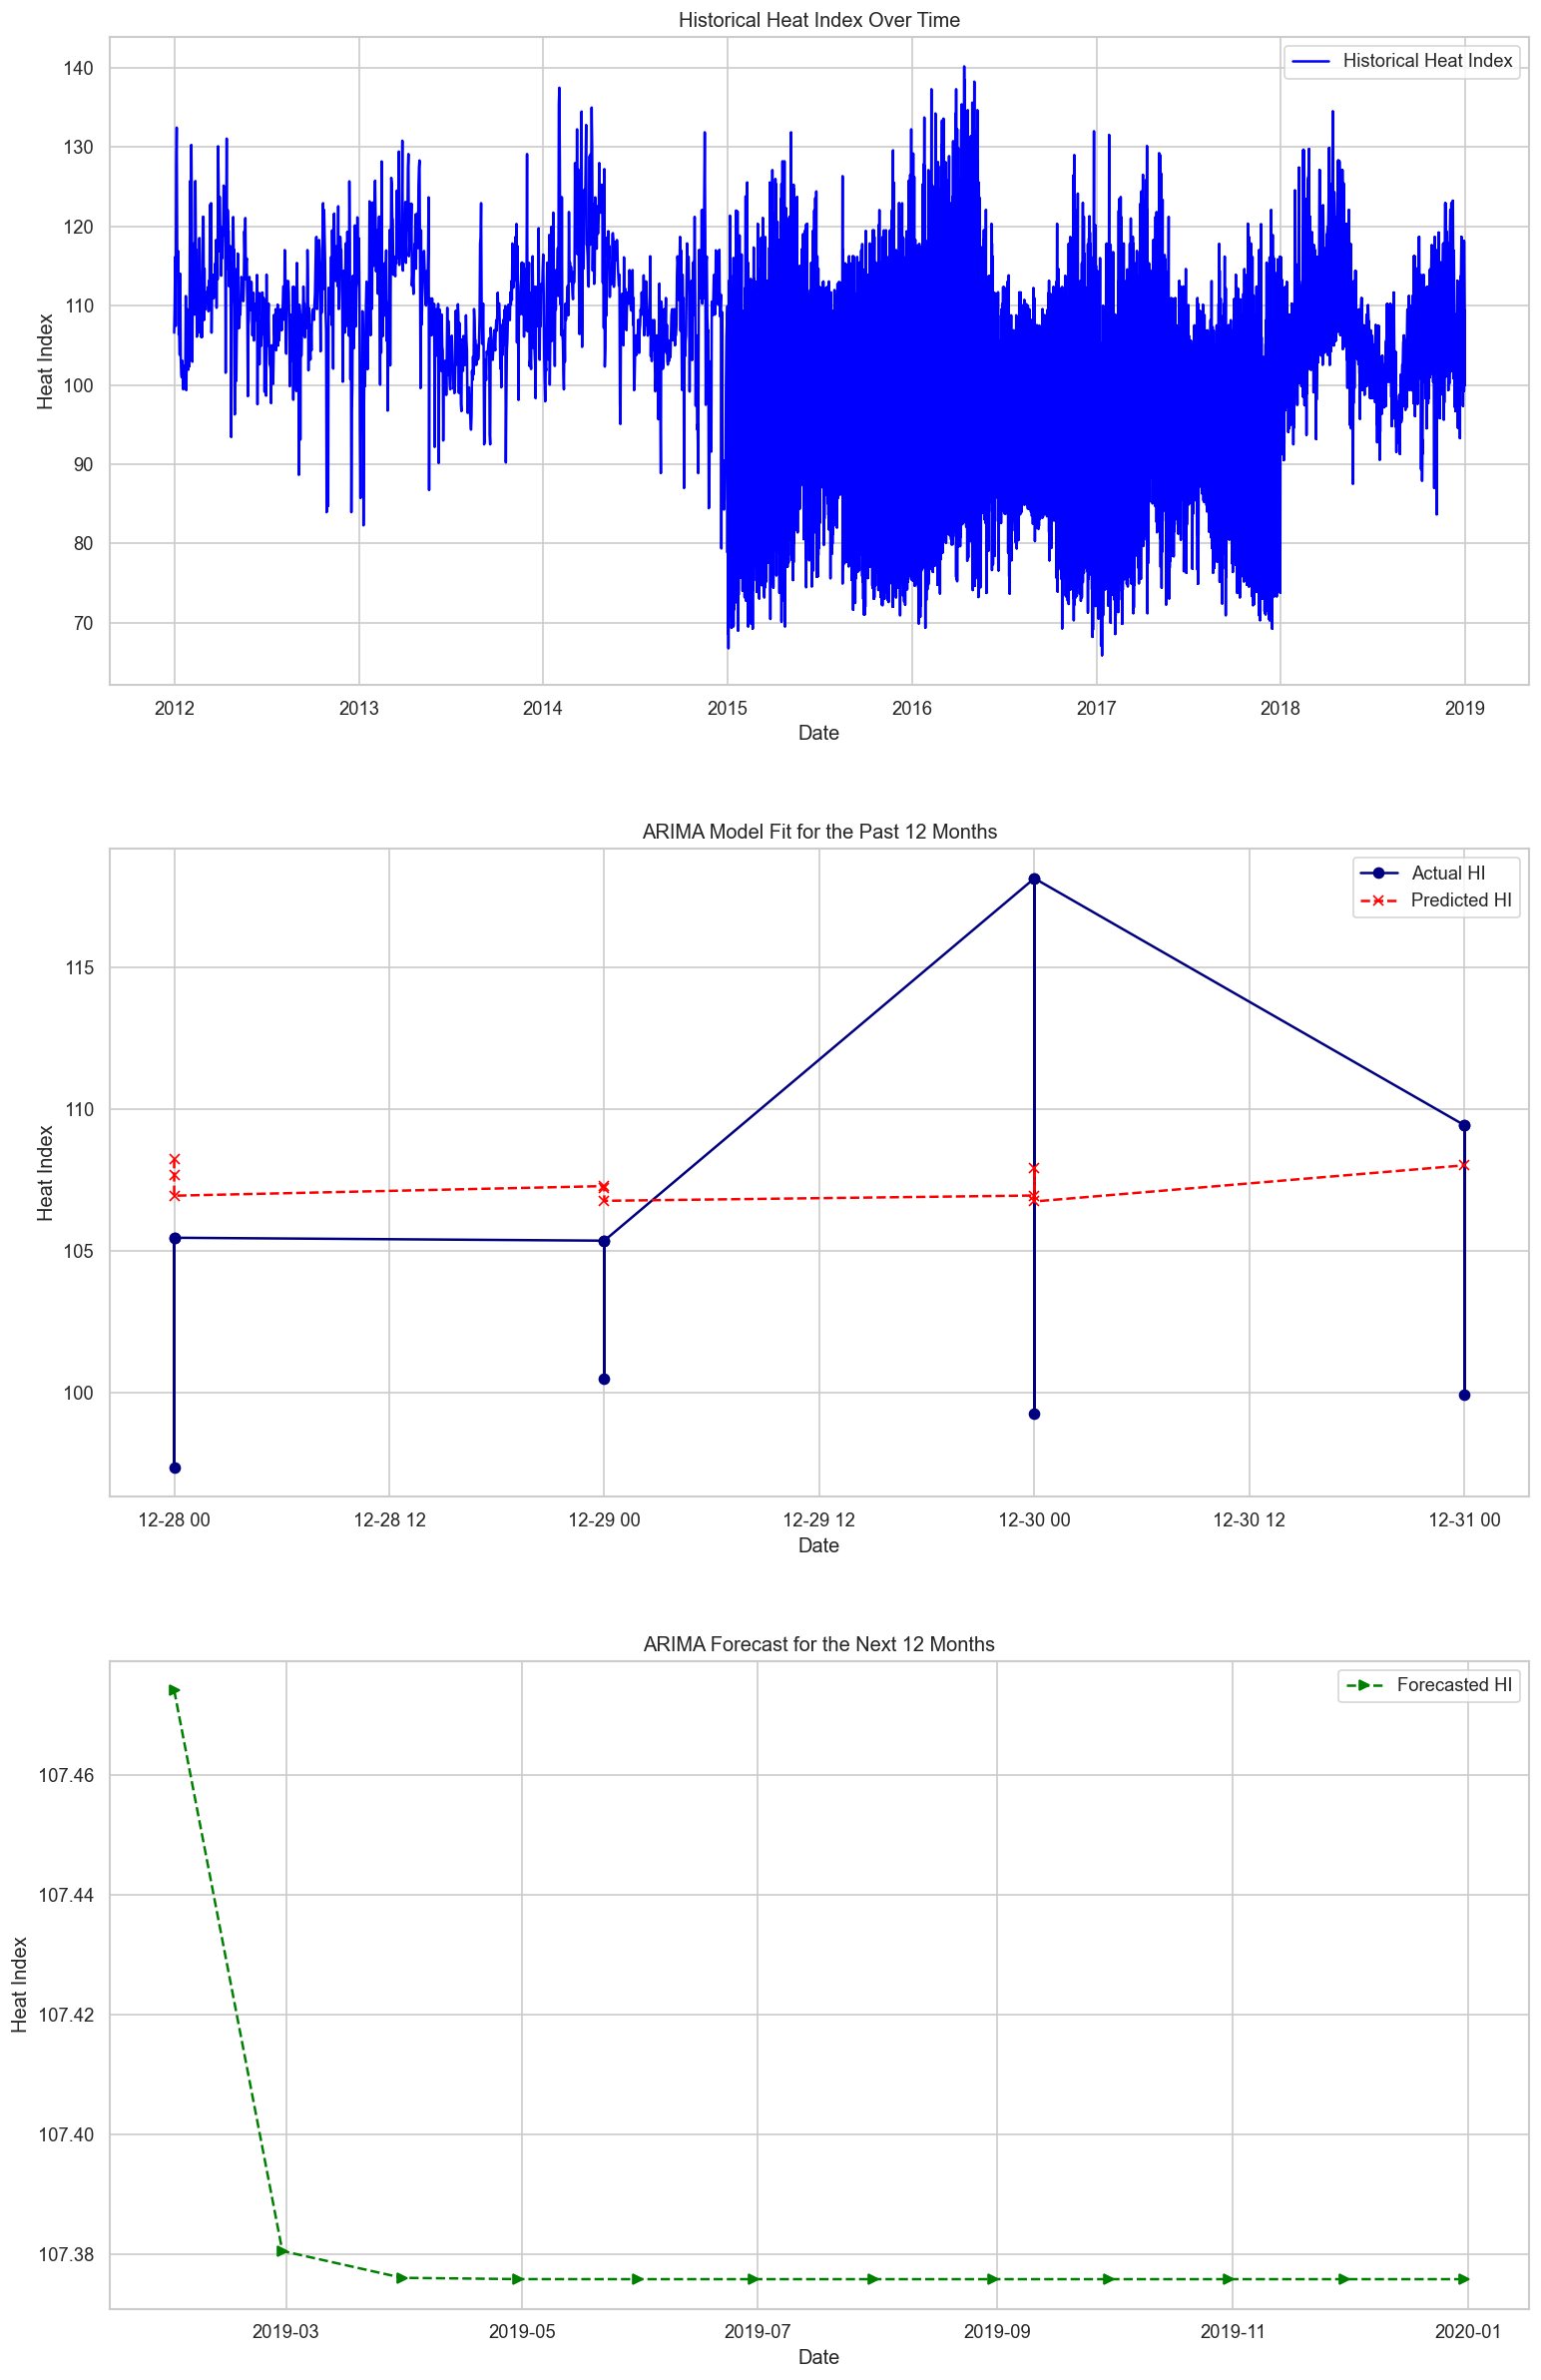

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style of seaborn for more aesthetically pleasing plots
sns.set(style='whitegrid')

# Create a subplot structure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 21), dpi=120)

# Historical Heat Index Data
axes[0].plot(combined_data['HI'], label='Historical Heat Index', color='blue')
axes[0].set_title('Historical Heat Index Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Heat Index')
axes[0].legend()

# Past 12 Months ARIMA Fit
axes[1].plot(recent_data.index[-12:], recent_data[-12:], label='Actual HI', marker='o', linestyle='-', color='navy')
axes[1].plot(past_12_months.index, past_12_months, color='red', linestyle='--', label='Predicted HI', marker='x')
axes[1].set_title('ARIMA Model Fit for the Past 12 Months')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Heat Index')
axes[1].legend()

# Next 12 Months ARIMA Forecast
forecast_dates = pd.date_range(start=combined_data.index[-1], periods=13, freq='M')[1:]  # Generate forecast dates
axes[2].plot(forecast_dates, next_12_months, color='green', linestyle='--', label='Forecasted HI', marker='>')
axes[2].set_title('ARIMA Forecast for the Next 12 Months')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Heat Index')
axes[2].legend()

# Improve layout and spacing
plt.tight_layout(pad=4.0)

# Show the plot
plt.show()
